In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
interval = '4h'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)

In [56]:
ma_candidates = [10, 20, 30, 50, 60, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200]

In [74]:
# Function to backtest strategy and calculate cumulative profit
def backtest_and_calculate_profit(df, ma):
    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 10000  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    stop_loss = 0 # No stop loss    
    
    stop_loss = 0.995 # 0.5% loss
    # stop_loss = 0.99 # 1% loss
    # stop_loss = 0.98 # 2% loss
    # stop_loss = 0.97 # 3% loss

    for i in range(0, len(df)):
        price = df['close'].iloc[i]

        # Stop loss check: Sell if the price drops more than 1% below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower 
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal
            if df['Signal'].iloc[i] == 1:  # Crosses above MA
                # if price < df['MA_200'].iloc[i]: # 장기 이평 아래면 안 산다. -> 하락추세로 판단
                #     continue
                if cash > 0:
                    purchase_price = price #* (1 + 0.01 / 100) # buy price 0.01% higher
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC")

            # Sell signal
            elif df['Signal'].iloc[i] == -1:  # Crosses below MA
                if btc_holding > 0:
                    sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    # df['portfolio_value'] = portfolio_value
    # print(f"Final value for MA {ma}: {portfolio_value:,.2f} USDT")
    return df

## Filter 2018, 2022

In [38]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

btc_data_2022 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2022])]
btc_data_2022 = btc_data_2022.drop(btc_data_2022[~pd.to_datetime(btc_data_2022['timestamp']).dt.year.isin([2022])].index)
btc_data_2022 = btc_data_2022.reset_index(drop=True)

In [39]:
btc_data_2018.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_100,MA_110,MA_120,MA_130,MA_140,MA_150,MA_160,MA_170,MA_180,MA_200
0,2018-01-01 00:00:00,13715.65,13715.65,13155.38,13410.03,1676.204807,13066.269,13603.527,13953.571333,13952.4830,...,15397.2857,15492.027000,15548.534167,15588.212000,15503.480643,15487.237467,15300.505563,15072.736176,14855.033556,14377.72440
1,2018-01-01 04:00:00,13434.98,13818.55,13322.15,13570.35,1302.214836,13191.905,13572.939,13870.749667,13957.8900,...,15357.5611,15469.636636,15521.620667,15574.137769,15486.983143,15482.354200,15311.570250,15086.882882,14869.696389,14396.09215
2,2018-01-01 08:00:00,13569.98,13735.24,13001.13,13220.56,1319.755931,13209.961,13497.717,13792.430667,13956.8802,...,15313.3969,15447.686364,15493.458667,15556.867615,15470.683143,15478.491400,15321.111250,15097.768765,14882.360722,14410.94980
3,2018-01-01 12:00:00,13220.56,13330.00,12750.00,13247.00,1831.933153,13290.660,13437.567,13728.830333,13956.7778,...,15270.4686,15424.702455,15467.919667,15544.152385,15455.733071,15464.738000,15330.780062,15107.781941,14896.456667,14425.03490
4,2018-01-01 16:00:00,13247.00,13290.65,12940.00,13240.37,1092.337234,13318.491,13385.585,13677.067667,13974.6674,...,15230.3723,15398.714909,15440.639417,15521.693615,15445.307071,15452.960400,15337.170125,15120.249882,14909.558056,14437.35525


In [52]:
btc_data = btc_data_2018

## Test {ma} MA

In [75]:
ma = 130
profit_df = backtest_and_calculate_profit(btc_data, ma)
portfolio_value = profit_df['portfolio_value'].iloc[-1]
print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")

2017-09-07 16:00:00: Bought BTC at 4,754.21, holding 2.1034 BTC
2017-09-07 20:00:00: Stop loss triggered! Sold BTC at 4,691.61, now holding 9,868.33 USDT
2017-09-12 04:00:00: Bought BTC at 4,361.00, holding 2.2629 BTC
2017-09-12 08:00:00: Sold BTC at 4,340.10, now holding 9,821.03 USDT

2017-09-27 04:00:00: Bought BTC at 3,968.00, holding 2.4751 BTC
2017-11-11 08:00:00: Sold BTC at 6,410.02, now holding 15,865.18 USDT

2017-11-13 12:00:00: Bought BTC at 6,589.99, holding 2.4075 BTC
2017-11-13 16:00:00: Stop loss triggered! Sold BTC at 6,366.97, now holding 15,328.26 USDT
2017-11-14 00:00:00: Bought BTC at 6,590.90, holding 2.3257 BTC
2017-11-14 04:00:00: Stop loss triggered! Sold BTC at 6,545.33, now holding 15,222.28 USDT
2017-11-14 16:00:00: Bought BTC at 6,532.06, holding 2.3304 BTC
2017-12-21 12:00:00: Sold BTC at 14,400.00, now holding 33,557.69 USDT

2017-12-21 20:00:00: Bought BTC at 15,492.64, holding 2.1660 BTC
2017-12-22 00:00:00: Stop loss triggered! Sold BTC at 13,780.00, n

## Test all ma candidates

In [88]:
portfolio_value_by_ma = {}
for ma in ma_candidates:
    profit = backtest_and_calculate_profit(btc_data, ma)
    portfolio_value_by_ma[ma] = profit['portfolio_value'].iloc[-1]

2017-08-19 20:00:00: Bought BTC at 4139.98, holding 2.4152 BTC
2017-08-20 00:00:00: Stop loss triggered! Sold BTC at 4094.62, now holding 9888.46 USDT
2017-08-22 16:00:00: Bought BTC at 3984.24, holding 2.4816 BTC
2017-08-25 20:00:00: Sold BTC at 4280.68, now holding 10622.06 USDT

2017-08-26 04:00:00: Bought BTC at 4319.70, holding 2.4587 BTC
2017-08-26 08:00:00: Sold BTC at 4288.72, now holding 10543.78 USDT

2017-08-26 20:00:00: Bought BTC at 4337.44, holding 2.4306 BTC
2017-08-27 20:00:00: Sold BTC at 4310.01, now holding 10475.00 USDT

2017-08-28 16:00:00: Bought BTC at 4321.65, holding 2.4236 BTC
2017-09-02 04:00:00: Sold BTC at 4697.71, now holding 11384.24 USDT

2017-09-05 08:00:00: Bought BTC at 4246.82, holding 2.6804 BTC
2017-09-05 12:00:00: Stop loss triggered! Sold BTC at 4151.00, now holding 11125.15 USDT
2017-09-05 16:00:00: Bought BTC at 4442.48, holding 2.5040 BTC
2017-09-05 20:00:00: Stop loss triggered! Sold BTC at 4366.47, now holding 10932.61 USDT
2017-09-08 08:00:

In [89]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA with a final portfolio value of {best_value:,.2f} USDT")


interval: 4h
Final value for MA 10: 98,520.82 USDT
Final value for MA 20: 275,350.52 USDT
Final value for MA 30: 118,454.62 USDT
Final value for MA 50: 180,399.54 USDT
Final value for MA 60: 160,528.50 USDT
Final value for MA 90: 493,265.68 USDT
Final value for MA 100: 644,414.86 USDT
Final value for MA 110: 454,969.84 USDT
Final value for MA 120: 573,748.99 USDT
Final value for MA 130: 818,633.10 USDT
Final value for MA 140: 729,427.08 USDT
Final value for MA 150: 475,950.32 USDT
Final value for MA 160: 532,848.47 USDT
Final value for MA 170: 809,169.78 USDT
Final value for MA 180: 507,430.02 USDT
Final value for MA 200: 124,208.99 USDT
The best performing for 4h is 130 MA with a final portfolio value of 818,633.10 USDT


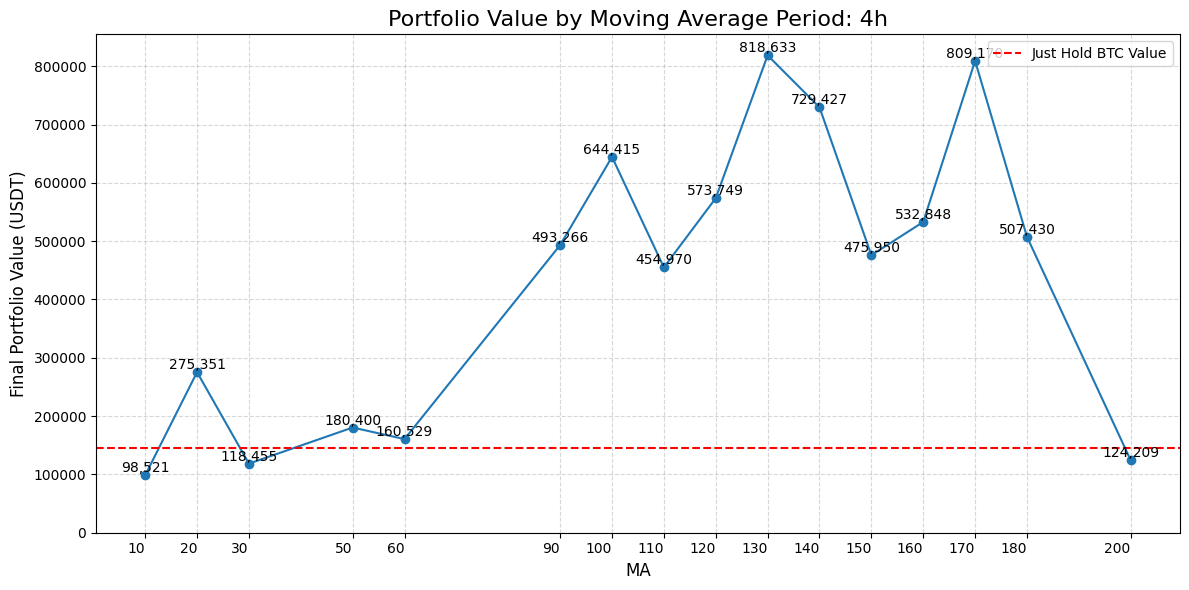

In [90]:
# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at 145,580.15
plt.axhline(y=145580.15, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


## Just holding BTC


In [57]:
# Function to calculate final value of holding BTC
def calculate_holding_value(df):
    initial_cash = 10000  # Start with $10,000 in cash

    # Buy BTC at the first available price
    initial_price = df['close'].iloc[0]
    btc_holding = initial_cash / initial_price  # Buy BTC with all available cash

    # Sell BTC at the last available price
    final_price = df['close'].iloc[-1]
    final_value = btc_holding * final_price  # Calculate the value of the BTC holding

    print(f"Initial BTC price: {initial_price:.2f} USDT")
    print(f"Final BTC price: {final_price:.2f} USDT")
    print(f"Final value of holding BTC: {final_value:,.2f} USDT")
    
    return final_value

In [ ]:

# Example usage
# Assuming 'df' is a DataFrame with your historical price data (e.g., 1-hour BTC/USDT prices)
final_value = calculate_holding_value(btc_data)

## Portfolio cumulative profit

In [ ]:
# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Import matplotlib.dates for date handling
import matplotlib.dates as mdates

# Plot the portfolio value over time
plt.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value')

# Set x-axis ticks to show only at one month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set tick every 1 month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date

# Hide unnecessary minor ticks
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_tick_params(which='minor', bottom=False)

# Remove unnecessary rotation for x-axis labels
plt.gca().xaxis.set_tick_params(rotation=45)  # Rotate only the major ticks for readability

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USDT)')
plt.title('Portfolio Value Over Time')

# Add legend
plt.legend()

# Ensure y-axis starts from 0
plt.ylim(bottom=0)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()